# Earthquake_standardization
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigendecomposition]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [2]:
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)

In [3]:
from haversine import haversine

##### 1. Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

In [5]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2004" & Year<="2011"').reset_index().iloc[:,1:]

##### 2. $f(x)$ 

In [112]:
f_true = _df.loc[:,"Magnitude"]

In [113]:
f = (f_true-f_true.mean())/f_true.std()

In [8]:
f@f ## SST 

4515.999999999998

In [9]:
(f-np.mean(f))@(f-np.mean(f)) ## SSE

4515.999999999998

In [10]:
(f*0-np.mean(f))@(f*0-np.mean(f)) ## SSH

1.788340861072209e-29

##### 3. Haversine Fomula 사용한 거리 정의

In [11]:
def dist(i,j):
    return haversine((_df.Latitude[i],_df.Longitude[i]),(_df.Latitude[j],_df.Longitude[j]))

##### 4. Definition of a weighted adjacency matrix $W$

$$W_{u,v}=\begin{cases}{exp(-\frac{[dist(u,v)]^2}{2\theta^2})} & \quad \text{if } dist(u,v) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [232]:
def weight(i,j,theta=10000,kappa=100000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [230]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [ ]:
plt.hist(W.reshape(-1))

##### 5. The weight edge function with temporal edge $(v_t,v_{t+1})$

$$W_{u_r,v_s}=\begin{cases} {W_{u,v}} & \quad \text{ if }  u,v \in V_t  \\ W_{u,v} \odot \beta  & \quad \text{if }u=v \text{ and } r=s-1 \\ 0 & \quad \text{otherwise} \end{cases}$$

In [14]:
def beta(i,j,b):
    if _df.Year[i] == _df.Year[j]:
        return 1
    elif abs(int(_df.Year[i]) - int(_df.Year[j])) == 1:
        return b
    else:
        return 0

In [15]:
_beta = np.array([[beta(i,j,1) for i in  range(len(_df))] for j in range(len(_df))])

In [152]:
_W = W @ _beta

##### 6. Definition of Graph Laplacian matrix
- $L = D - W$

In [153]:
D = np.diag(_W.sum(axis=1))

In [154]:
L = D - _W

##### 7. Eigendecomposition
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [155]:
λ, Ψ = np.linalg.eig(L)

In [156]:
Λ = np.diag(λ)

##### 8. Principal components Analysis

- $comp_k = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, n$
- $p = \sum_{1}^{n} comp_{1}^{2},\sum_{1}^{n} comp_{2}^{2},…,\sum_{1}^{n} comp_{n}^{2}$
- $p = \frac{p}{\sum(p)}$

In [157]:
def p(i):
    return sum((f @ np.outer( Ψ[:,i], Ψ[:,i]))**2)

In [158]:
array_1 = np.array([p(i) for i in range(1,len(_df))])
varprop = array_1/array_1.sum()
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [161]:
_df["comp1"] = f @ np.outer( Ψ[:,0], Ψ[:,0])
_df["comp2"] = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])
_df["comp3"] = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])
_df["comp4"] = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])
_df["comp5"] = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])
_df["comp6"] = f @ np.outer( Ψ[:,_indexlst[4]], Ψ[:,_indexlst[4]])
_df["comp7"] = f @ np.outer( Ψ[:,_indexlst[5]], Ψ[:,_indexlst[5]])

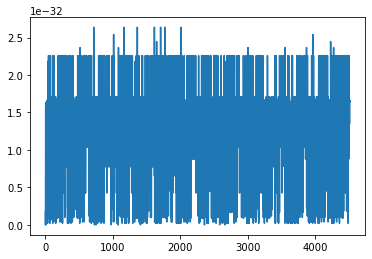

In [163]:
plt.plot((f @ np.outer(Ψ[:,0], Ψ[:,0]))**2)

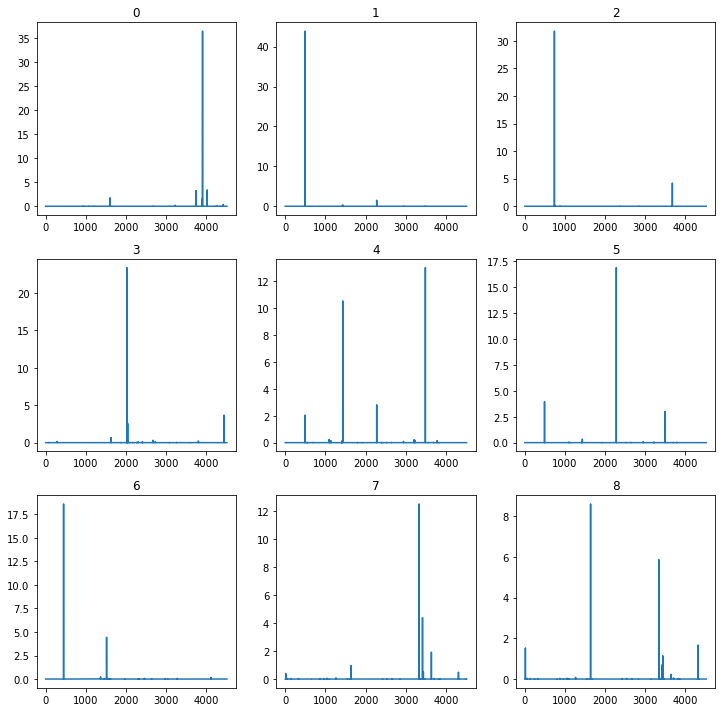

In [164]:
fig,ax =plt.subplots(3,3)
k=0
for i in range(3):
    for j in range(3):
        ax[i][j].plot((f @ np.outer(Ψ[:,_indexlst[k]], Ψ[:,_indexlst[k]]))**2)
        # ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(10)            
fig.set_figheight(10)
fig.tight_layout()        

##### **2004**, $n=571$

In [165]:
_G1 = nx.Graph(_W[:len(_df.query('Year<="2004"')),:len(_df.query('Year<="2004"'))]-np.identity(len(_df.query('Year=="2004"'))))
_pos1 = nx.spring_layout(_G1,iterations=20)
m_pos1 = list(zip(_df.query('Year=="2004"').Longitude,_df.query('Year=="2004"').Latitude))

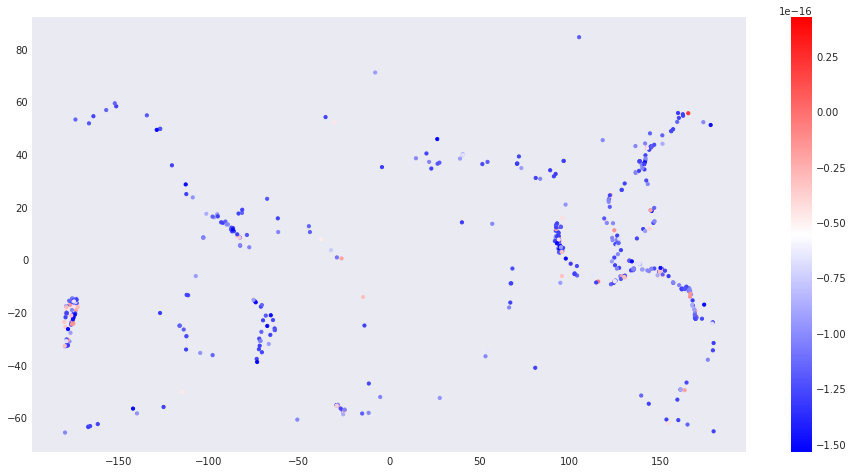

In [166]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

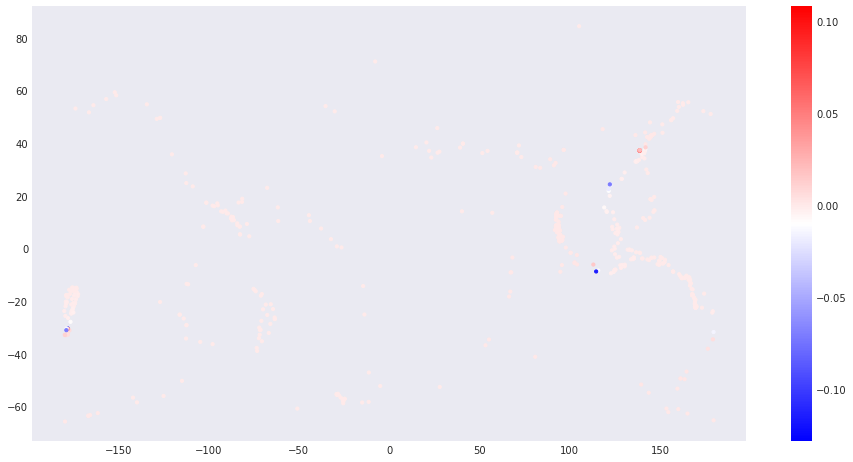

In [167]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

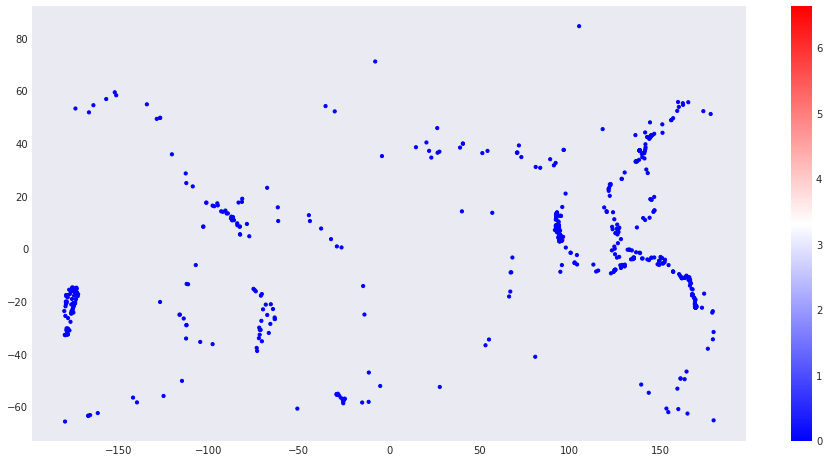

In [168]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

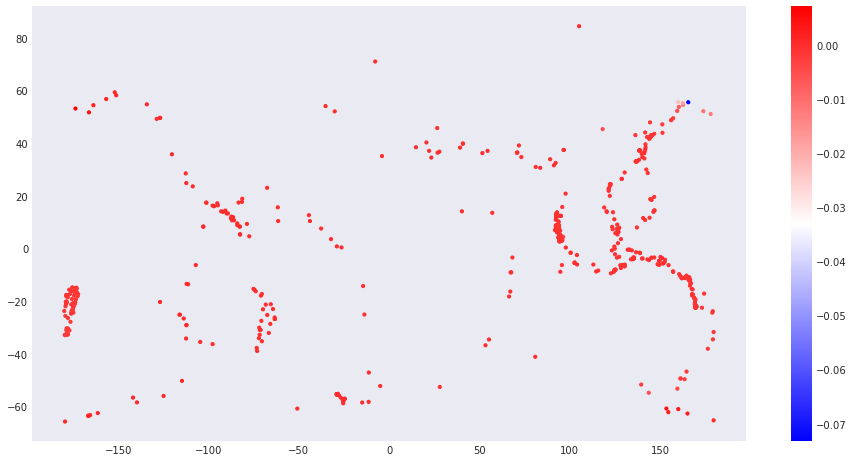

In [169]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

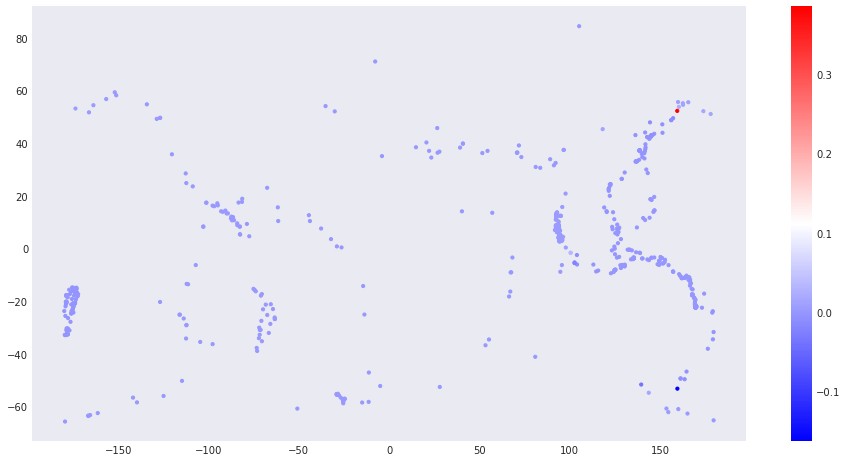

In [170]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

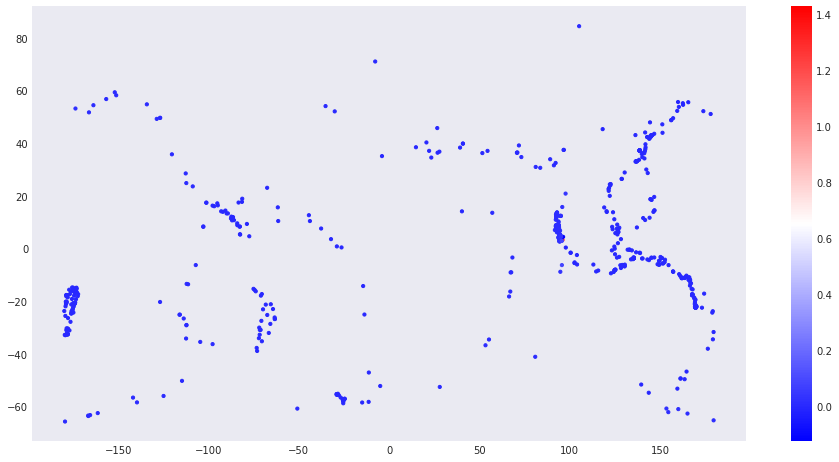

In [171]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

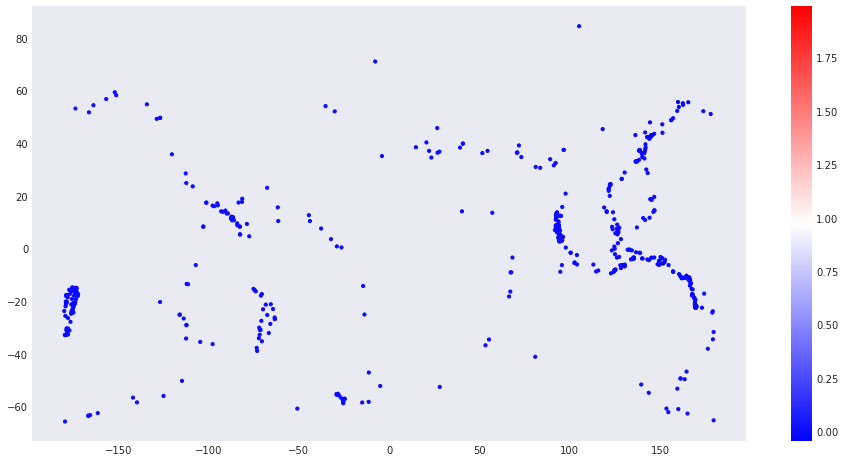

In [172]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2005**, $n=533$

In [173]:
_G2 = nx.Graph(_W[len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"')),len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"'))]-np.identity(len(_df.query('Year=="2005"'))))
_pos2 = nx.spring_layout(_G2,iterations=20)
m_pos2 = list(zip(_df.query('Year=="2005"').Longitude,_df.query('Year=="2005"').Latitude))

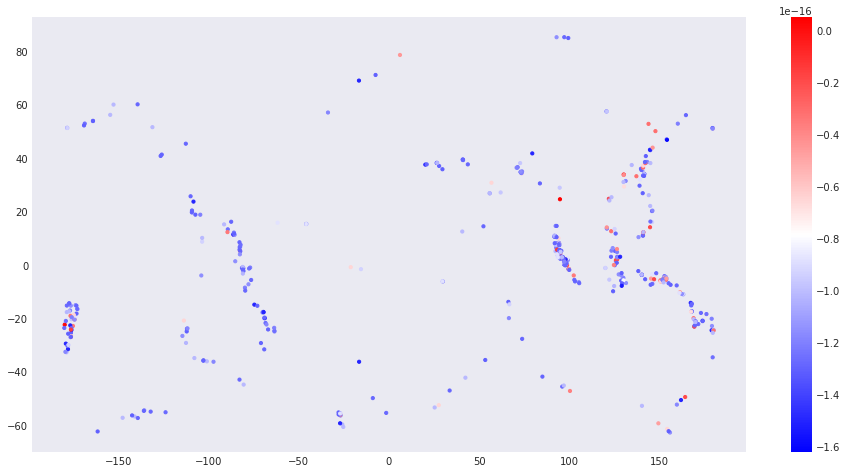

In [174]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

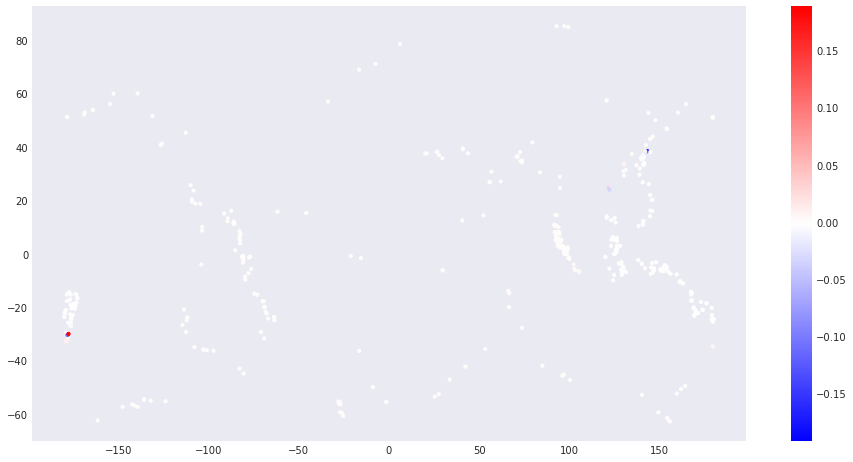

In [175]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

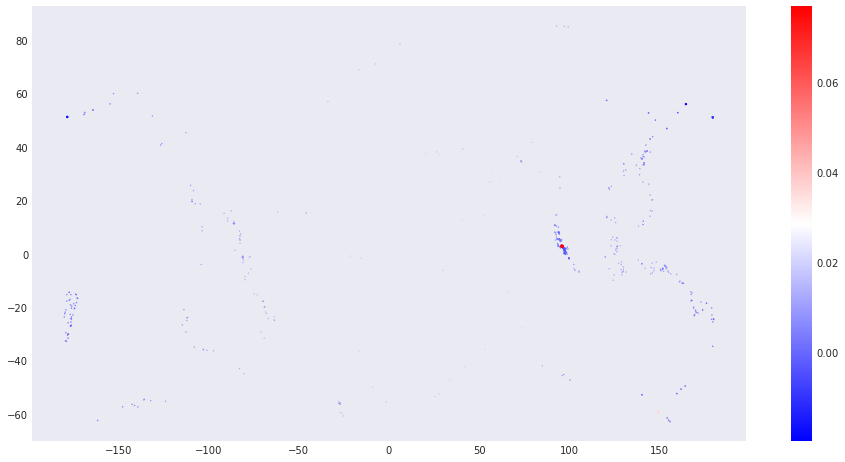

In [176]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp3,node_size = np.abs(_df.query('Year=="2005"').comp3)*100, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

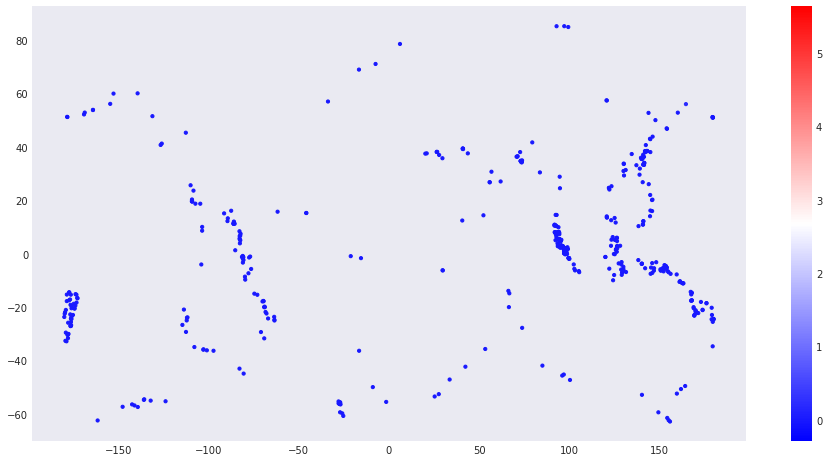

In [177]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

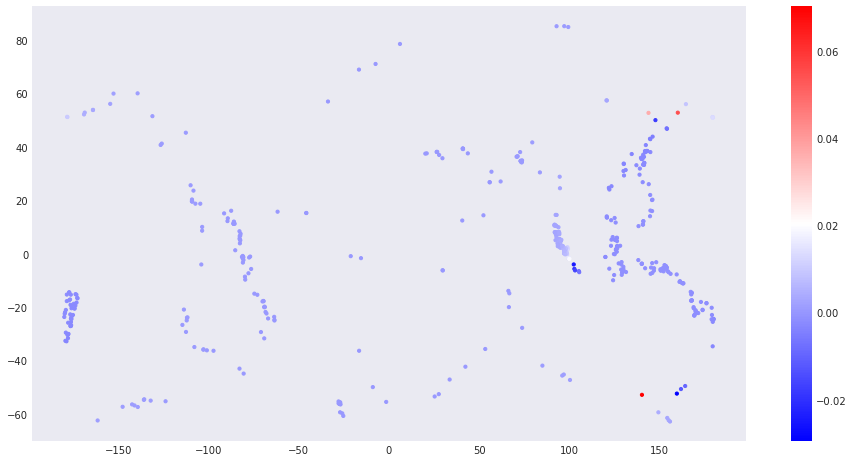

In [178]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

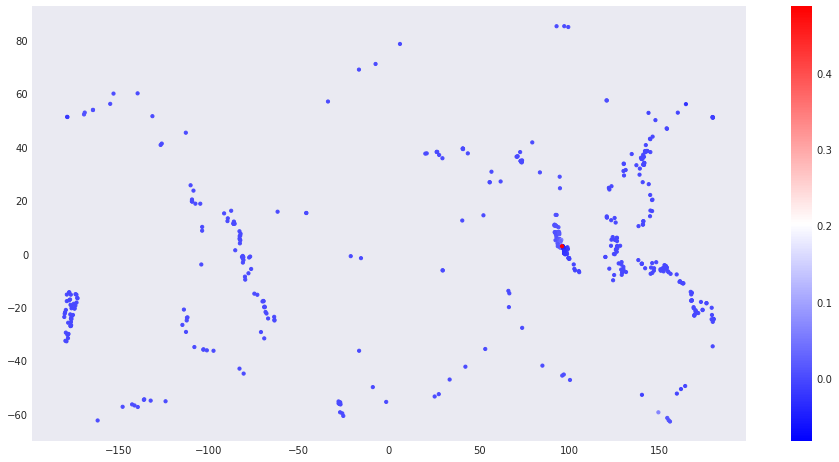

In [179]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

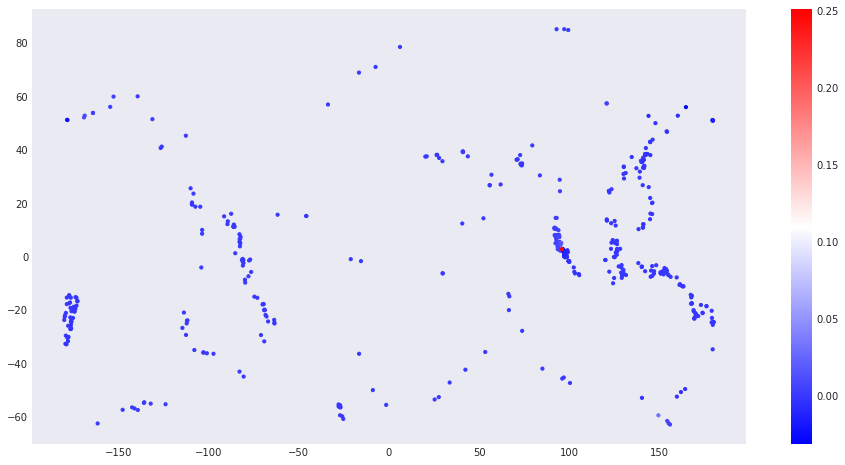

In [180]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2006**, $n=512$

In [181]:
_G3 = nx.Graph(_W[len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"')),len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"'))]-np.identity(len(_df.query('Year=="2006"'))))
_pos3 = nx.spring_layout(_G3,iterations=20)
m_pos3 = list(zip(_df.query('Year=="2006"').Longitude,_df.query('Year=="2006"').Latitude))

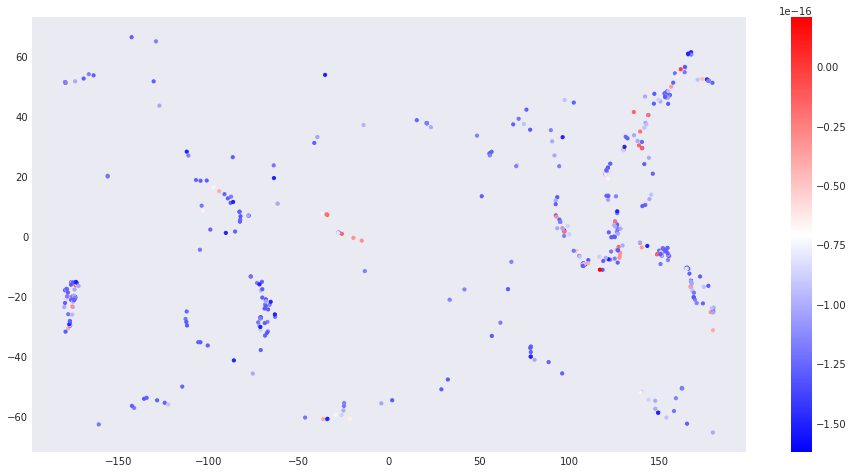

In [182]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

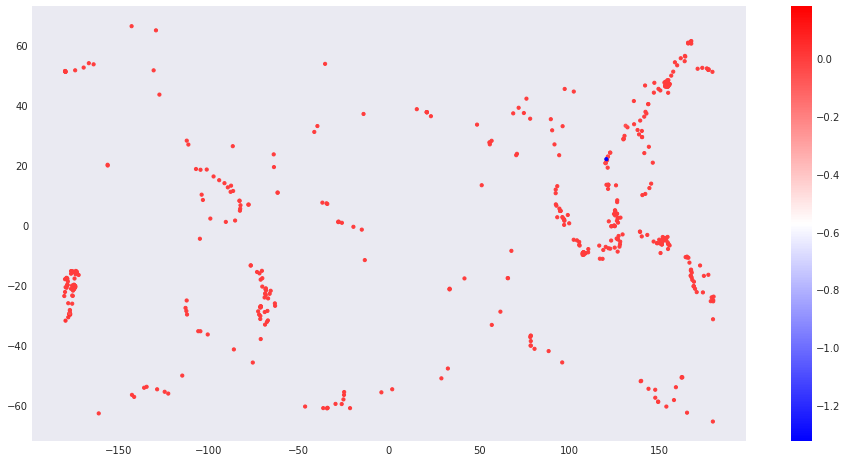

In [183]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

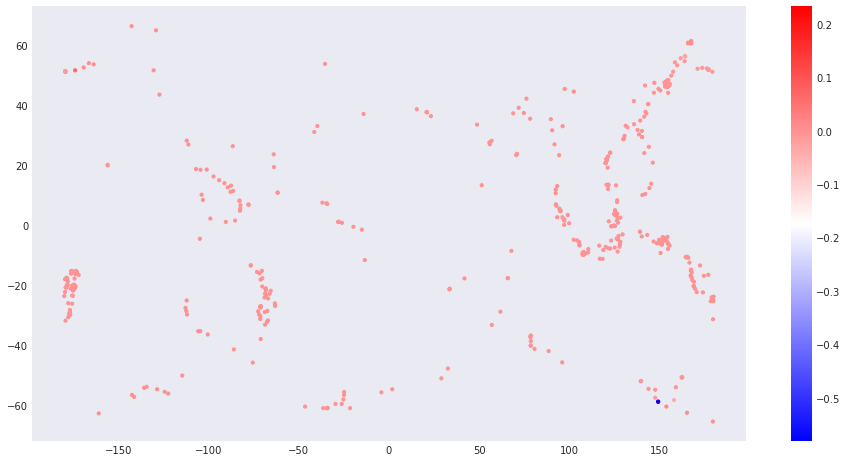

In [184]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

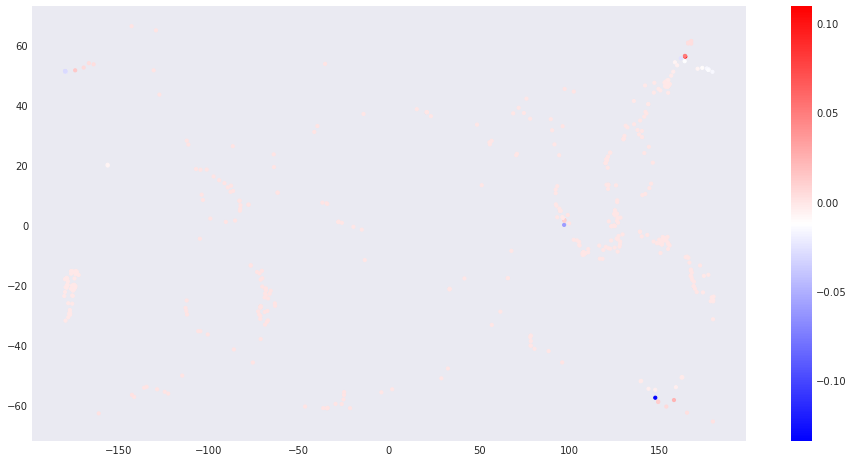

In [185]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

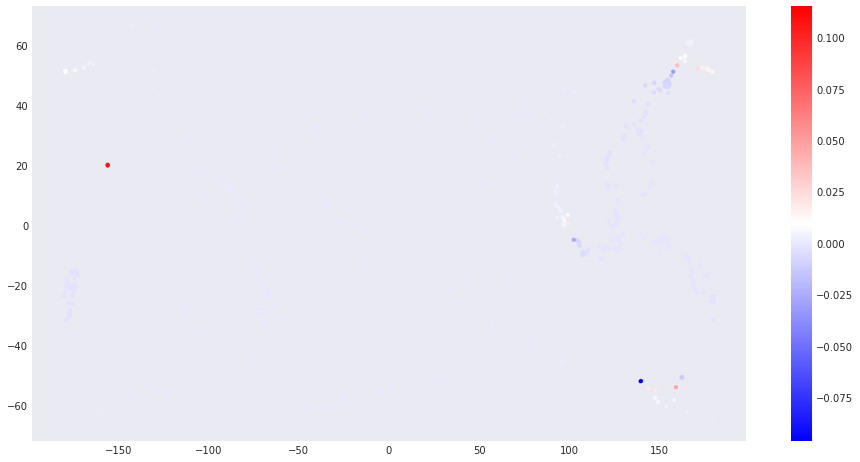

In [186]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

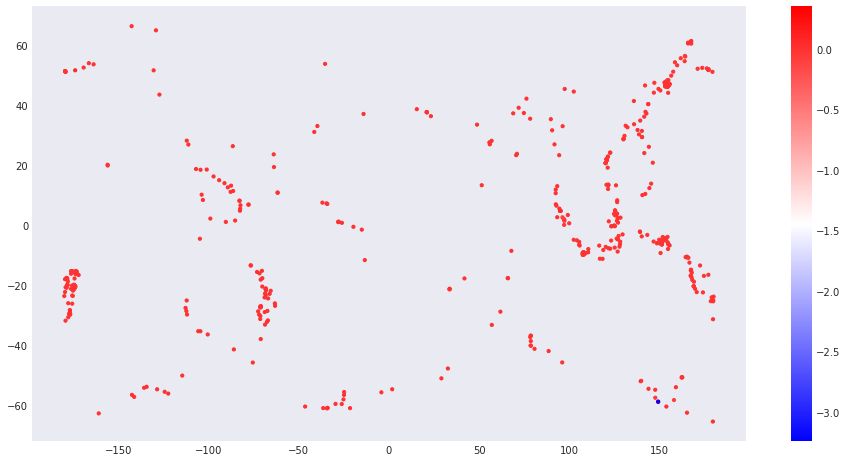

In [187]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

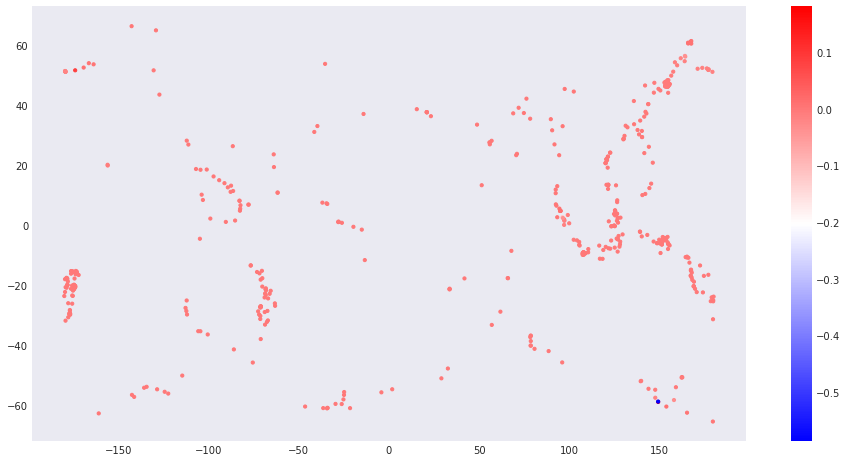

In [188]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2007**, $n=608$

In [189]:
_G4 = nx.Graph(_W[len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"')),len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"'))]-np.identity(len(_df.query('Year=="2007"'))))
_pos4 = nx.spring_layout(_G4,iterations=20)
m_pos4 = list(zip(_df.query('Year=="2007"').Longitude,_df.query('Year=="2007"').Latitude))

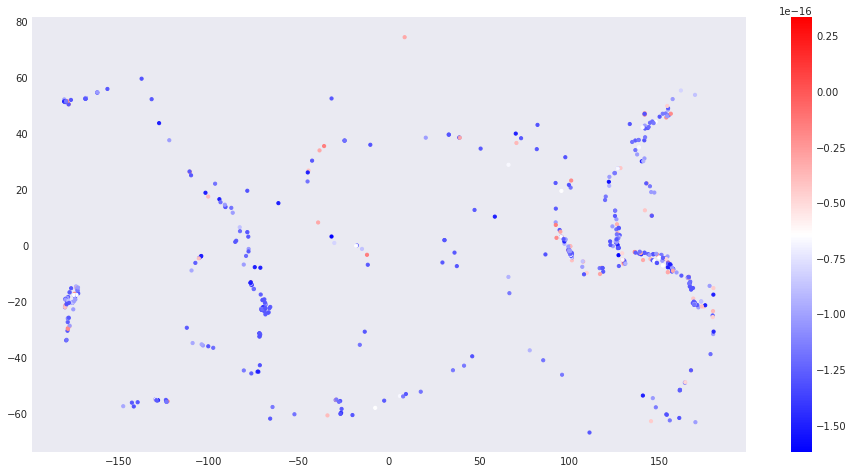

In [190]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

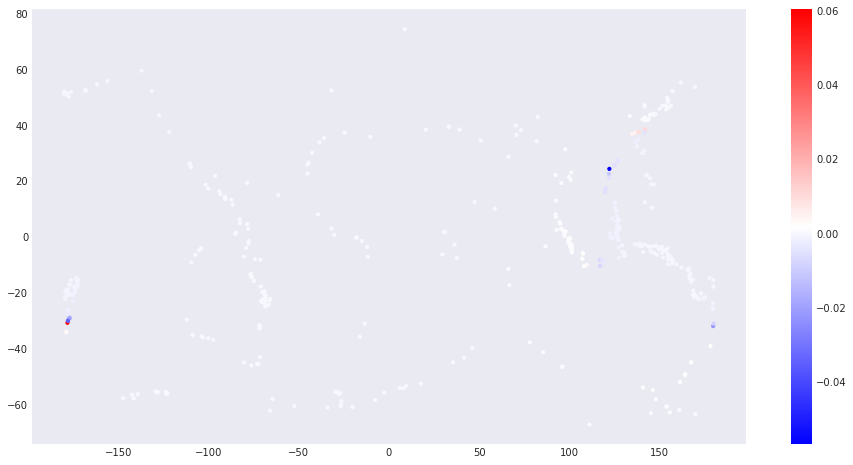

In [191]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

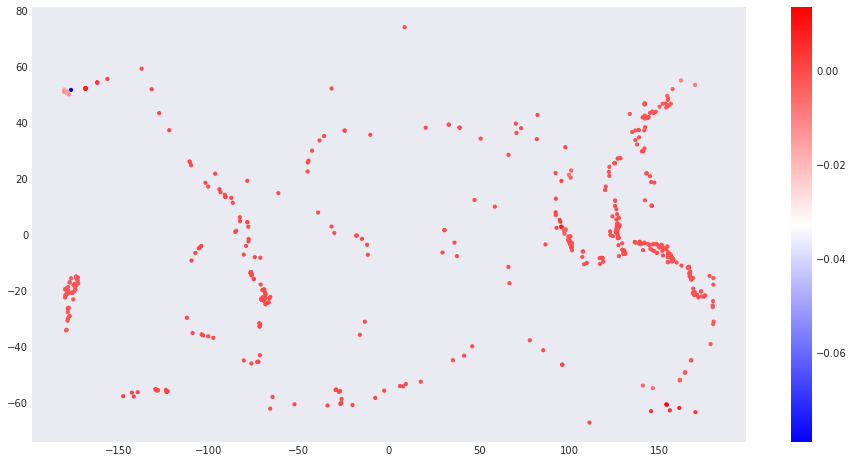

In [192]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp3,node_size =10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

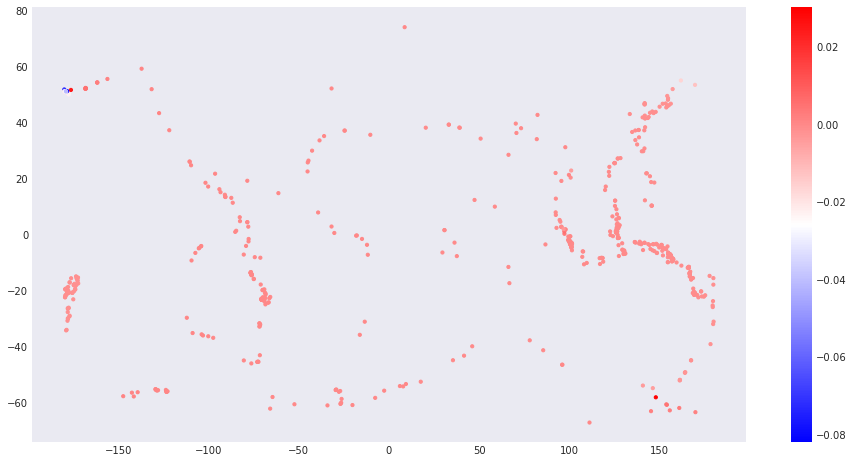

In [193]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

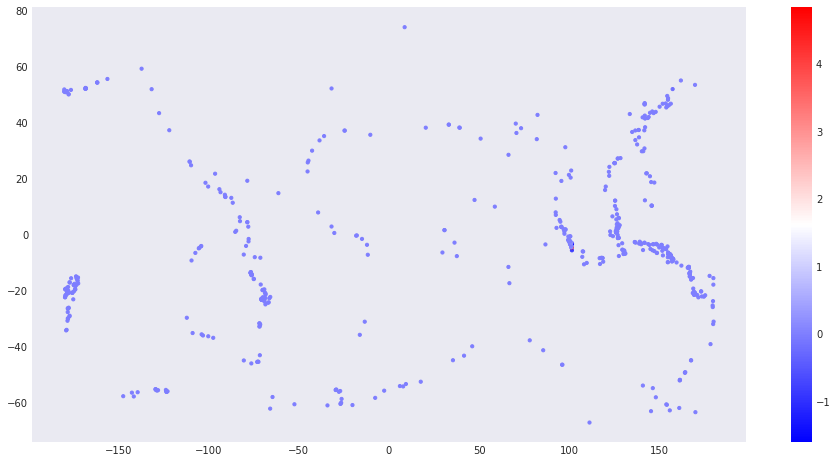

In [194]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

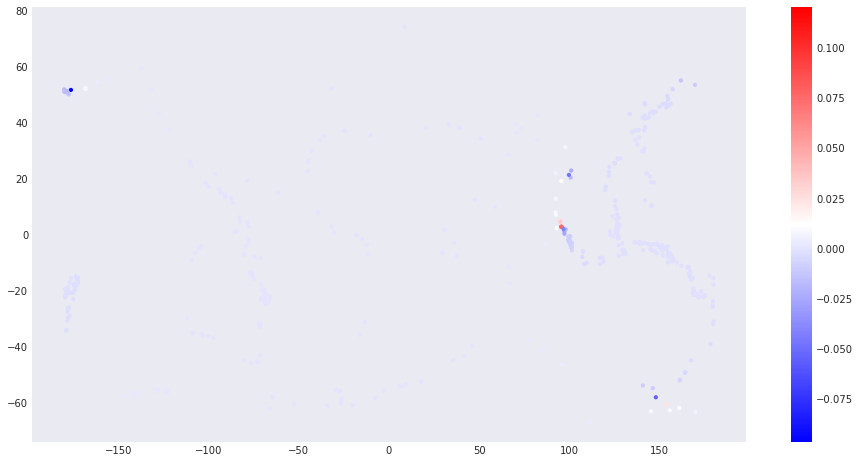

In [195]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

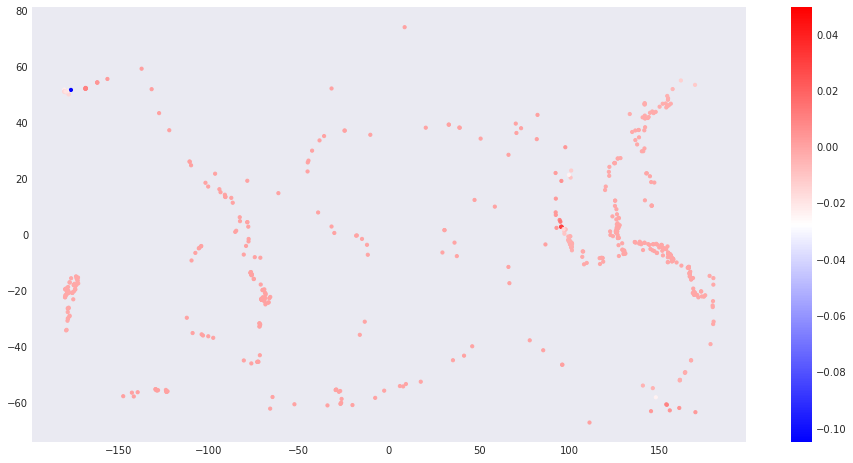

In [196]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2008**, $n=508$

In [197]:
_G5 = nx.Graph(_W[len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"')),len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"'))]-np.identity(len(_df.query('Year=="2008"'))))
_pos5 = nx.spring_layout(_G5,iterations=20)
m_pos5 = list(zip(_df.query('Year=="2008"').Longitude,_df.query('Year=="2008"').Latitude))

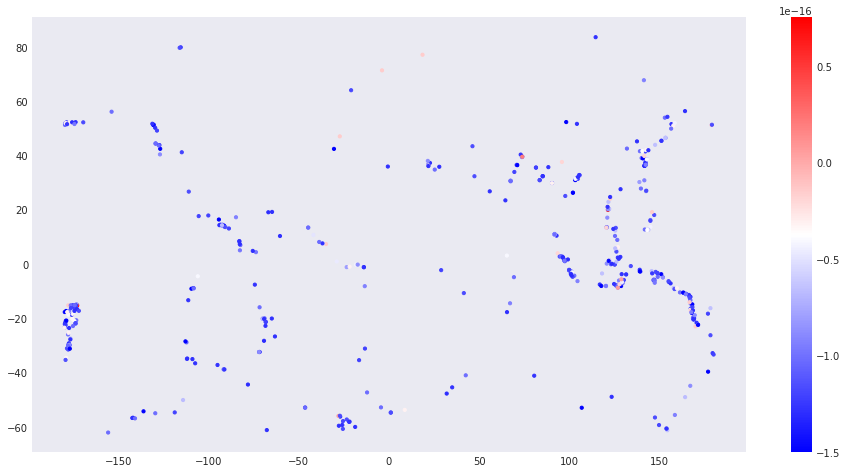

In [198]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

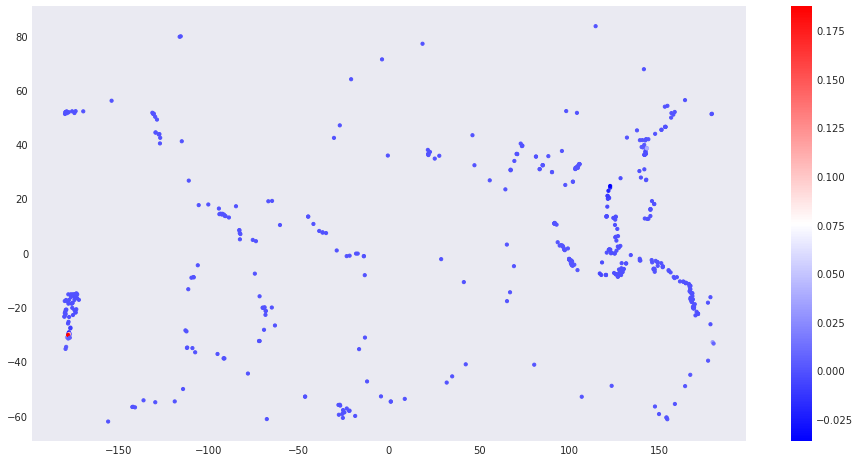

In [199]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

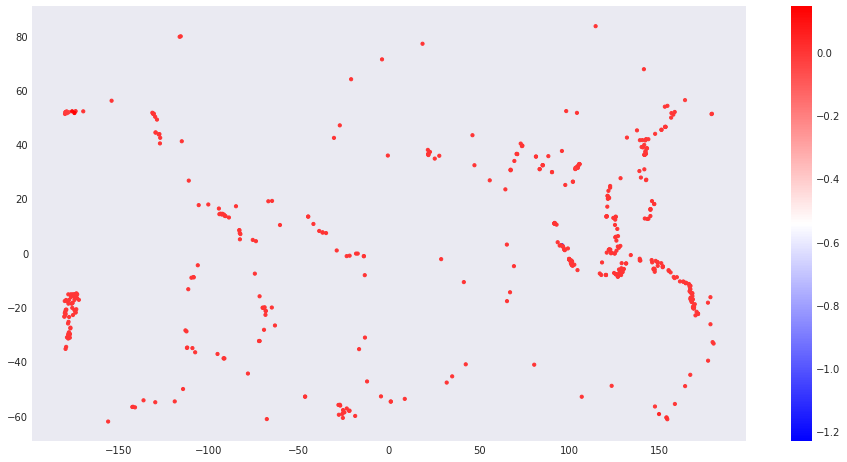

In [200]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

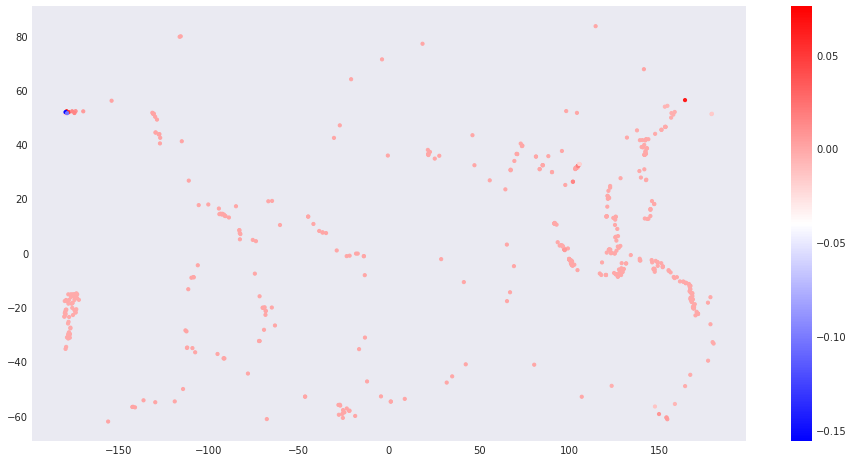

In [201]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

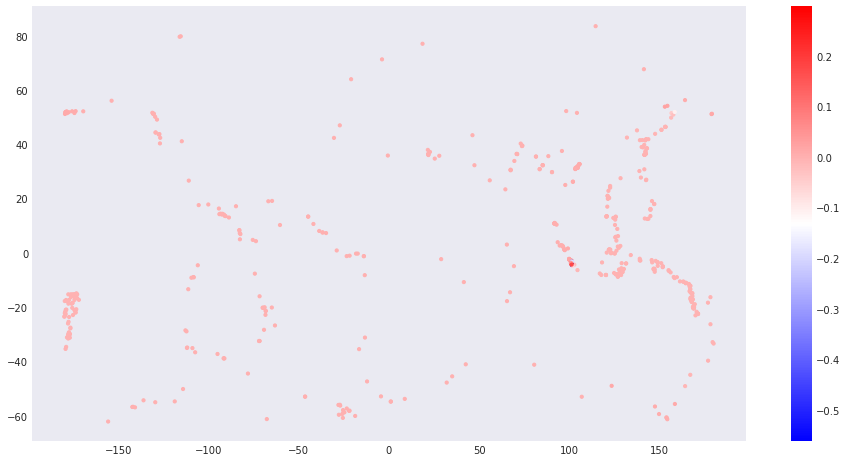

In [202]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

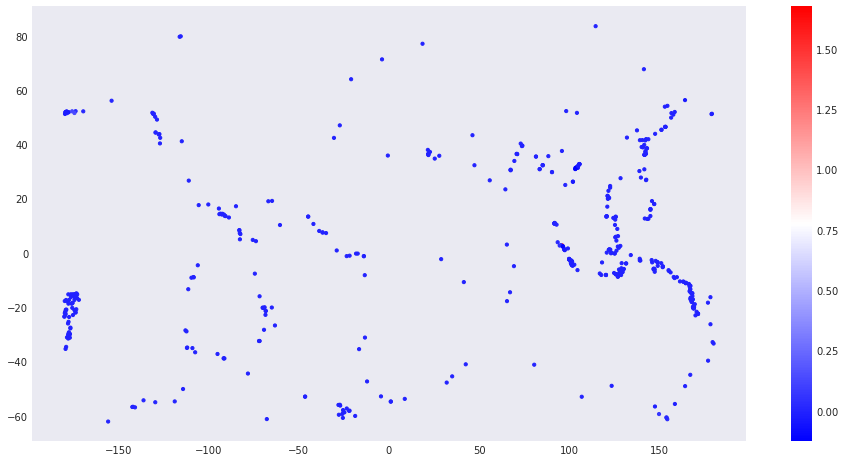

In [203]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

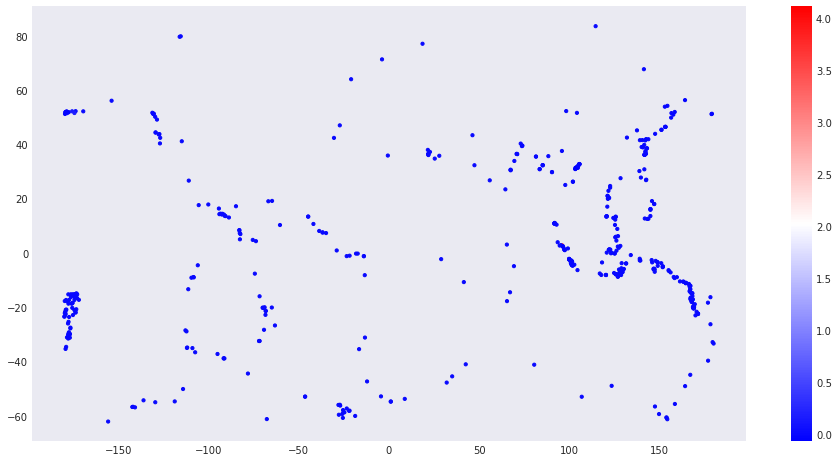

In [204]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2009**, $n=517$

In [205]:
_G6 = nx.Graph(_W[len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"')),len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"'))]-np.identity(len(_df.query('Year=="2009"'))))
_pos6 = nx.spring_layout(_G6,iterations=20)
m_pos6 = list(zip(_df.query('Year=="2009"').Longitude,_df.query('Year=="2009"').Latitude))

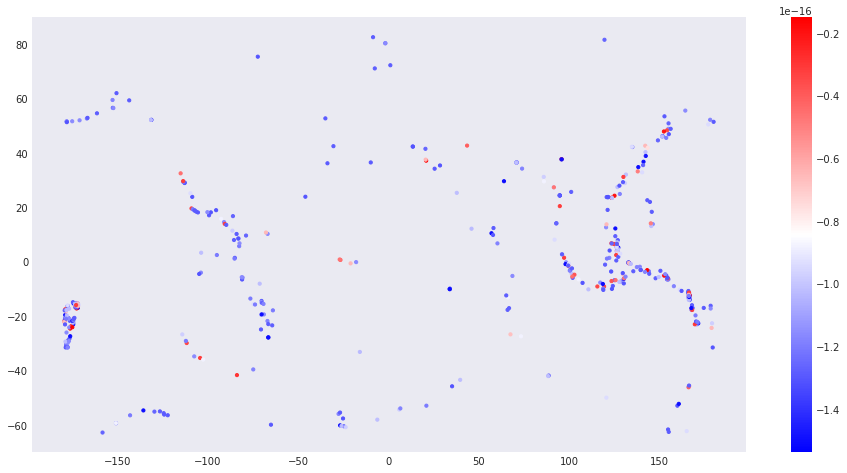

In [206]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

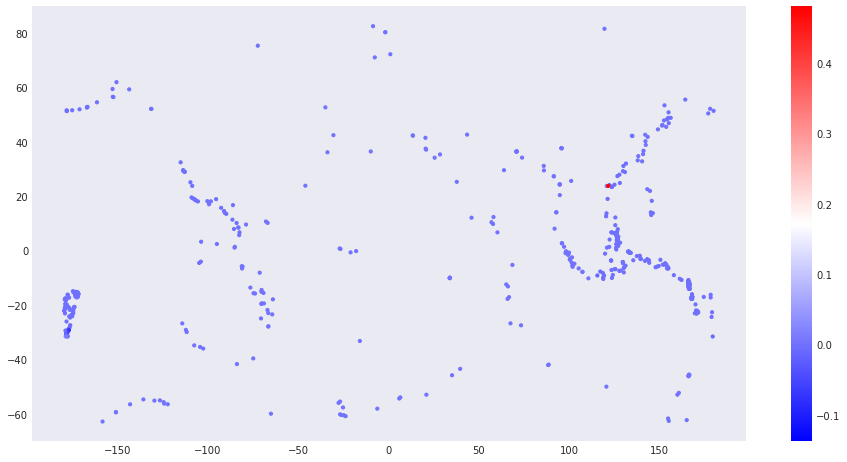

In [207]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

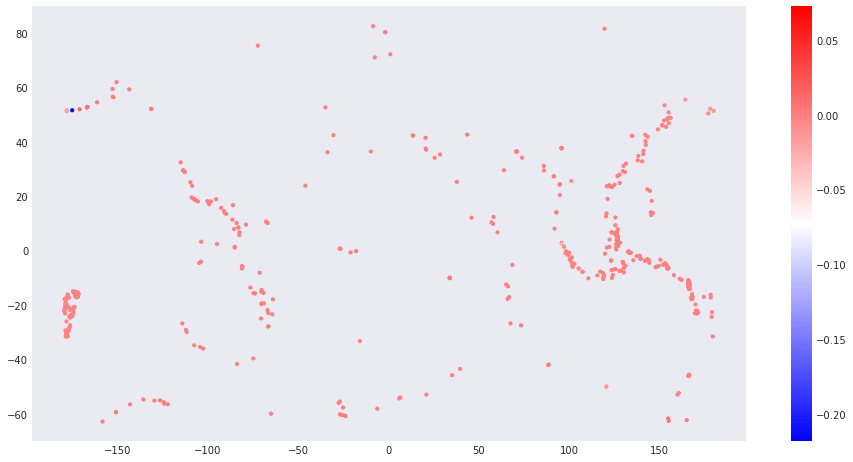

In [208]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

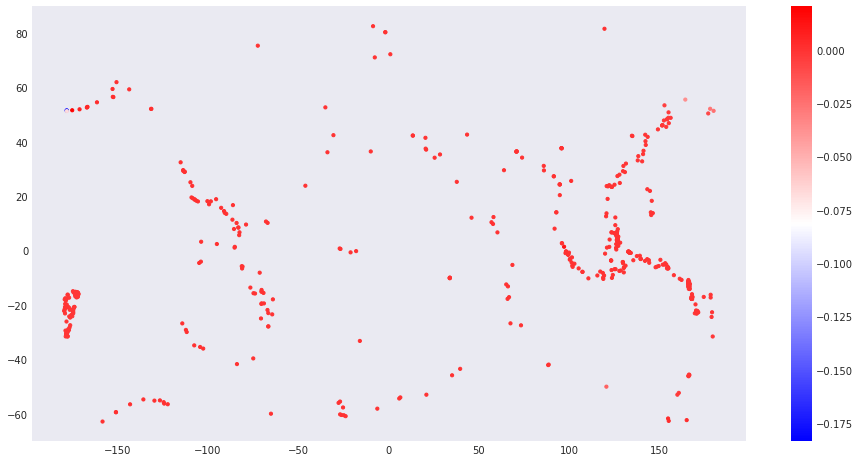

In [209]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

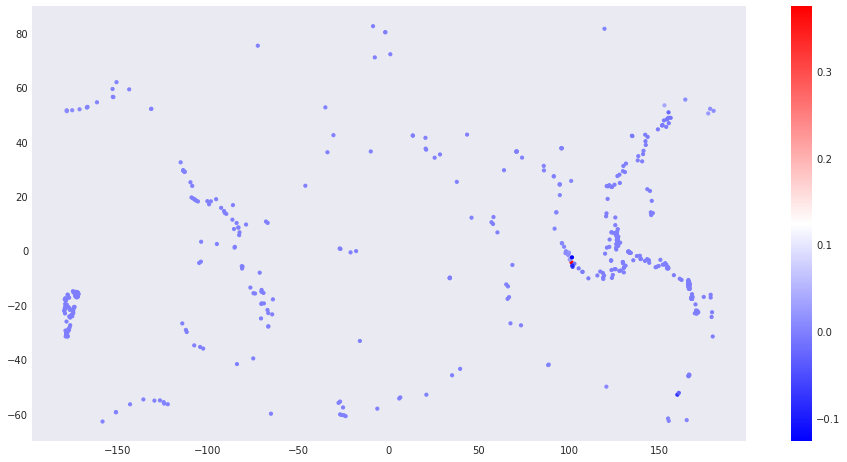

In [210]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

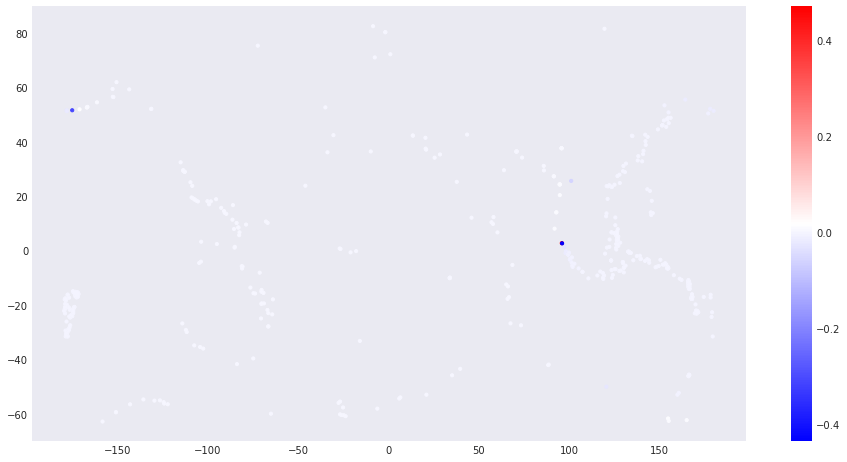

In [211]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

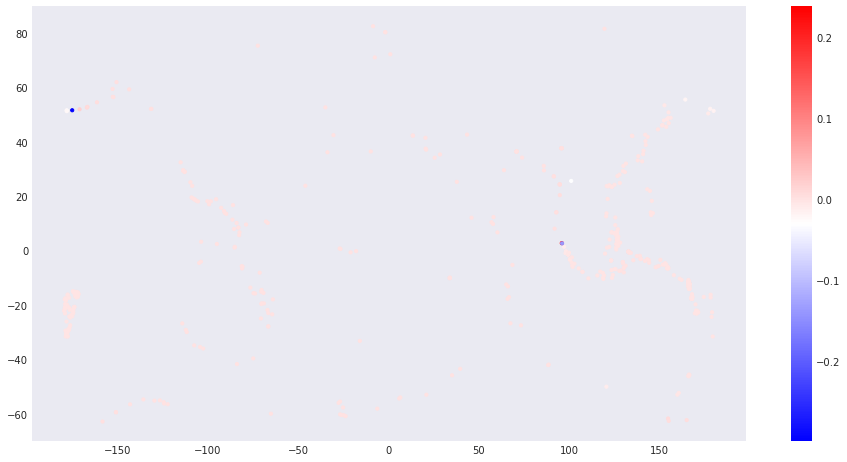

In [212]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2010**, $n=560$

In [213]:
_G7 = nx.Graph(_W[len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"')),len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"'))]-np.identity(len(_df.query('Year=="2010"'))))
_pos7 = nx.spring_layout(_G7,iterations=20)
m_pos7 = list(zip(_df.query('Year=="2010"').Longitude,_df.query('Year=="2010"').Latitude))

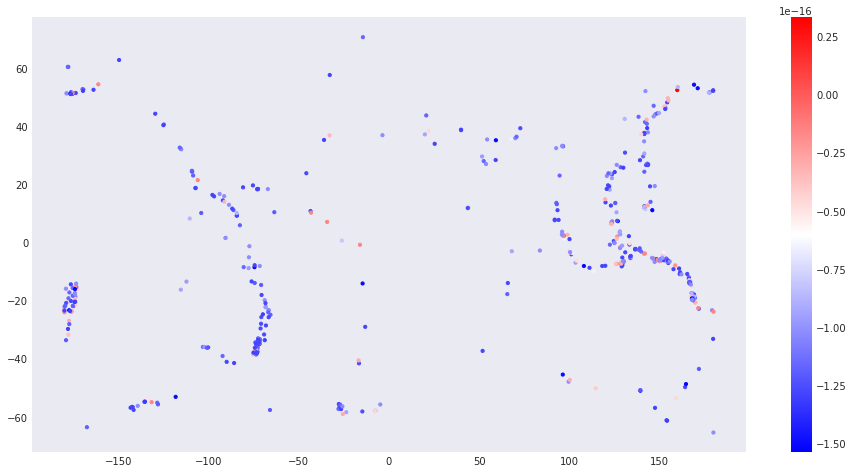

In [214]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

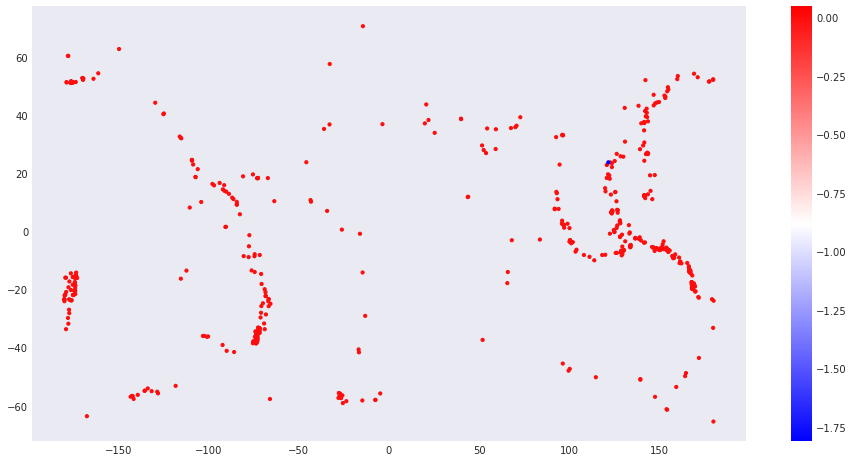

In [215]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

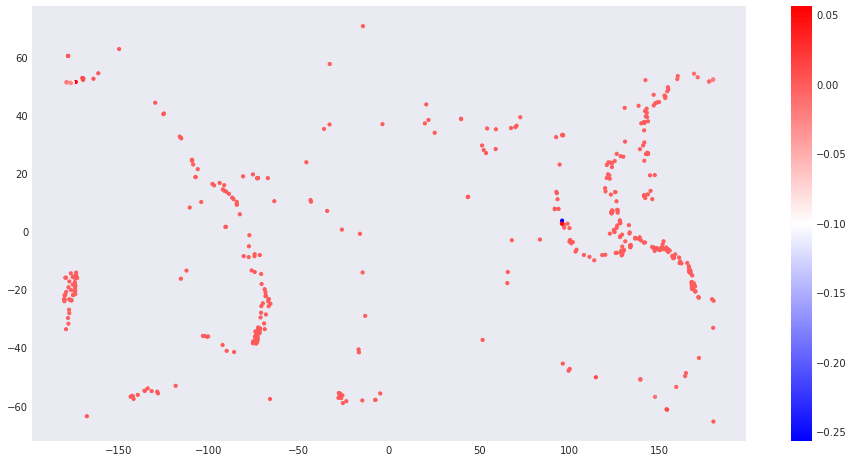

In [216]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

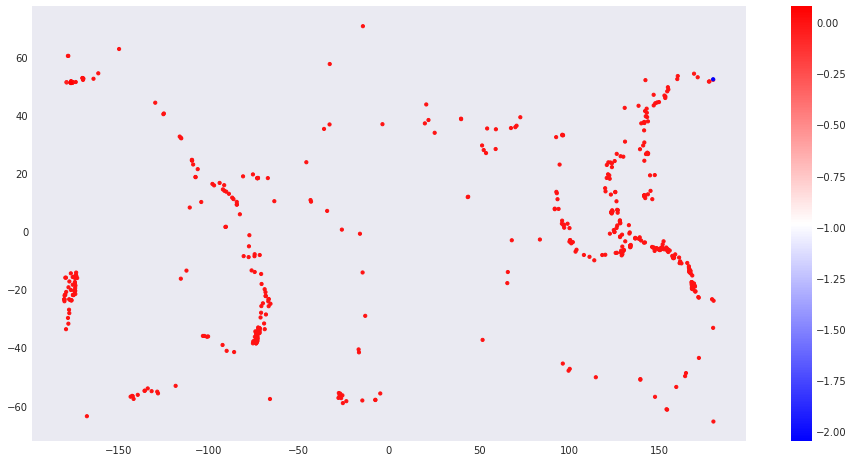

In [217]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

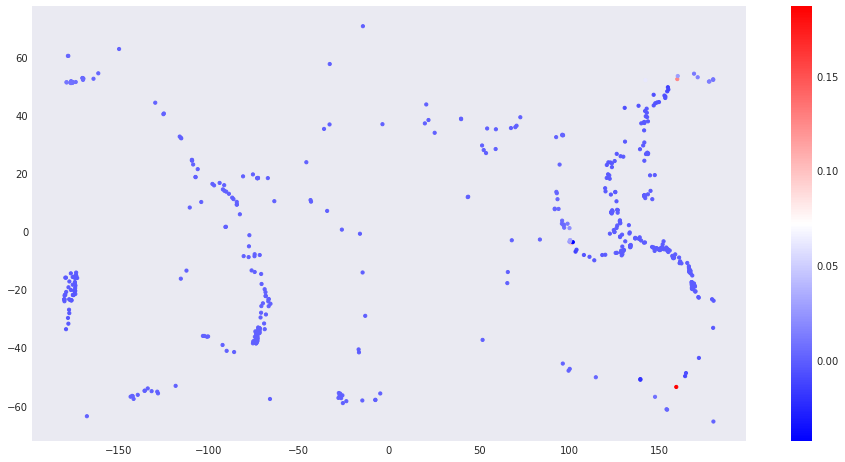

In [218]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

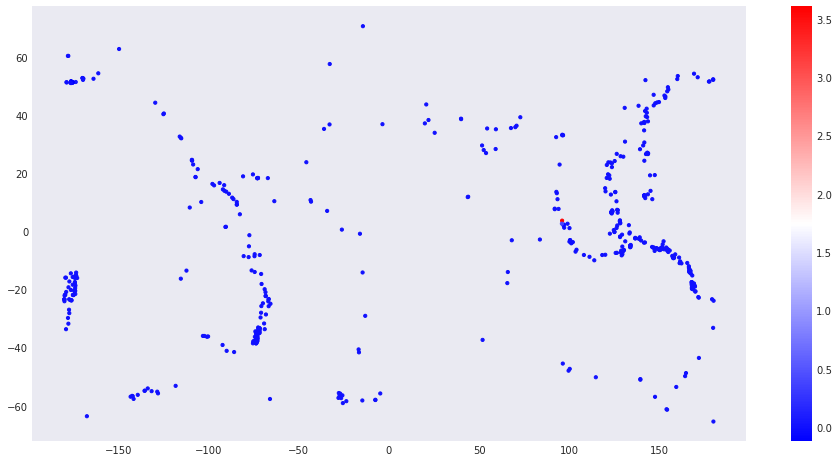

In [219]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

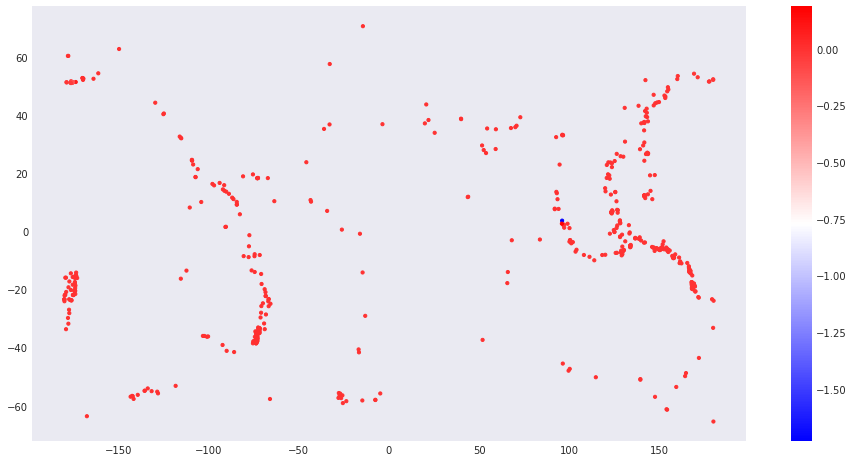

In [220]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2011**, $n=712$

In [221]:
_G8 = nx.Graph(_W[len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"')),len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"'))]-np.identity(len(_df.query('Year=="2011"'))))
_pos8 = nx.spring_layout(_G8,iterations=20)
m_pos8 = list(zip(_df.query('Year=="2011"').Longitude,_df.query('Year=="2011"').Latitude))

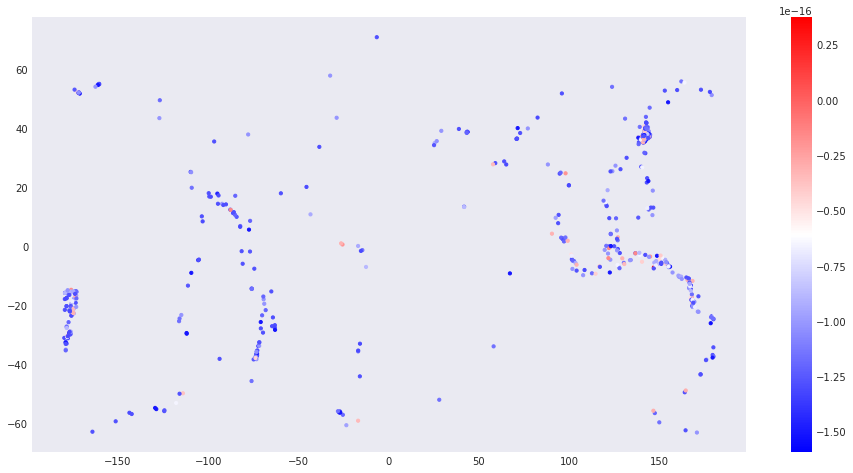

In [222]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

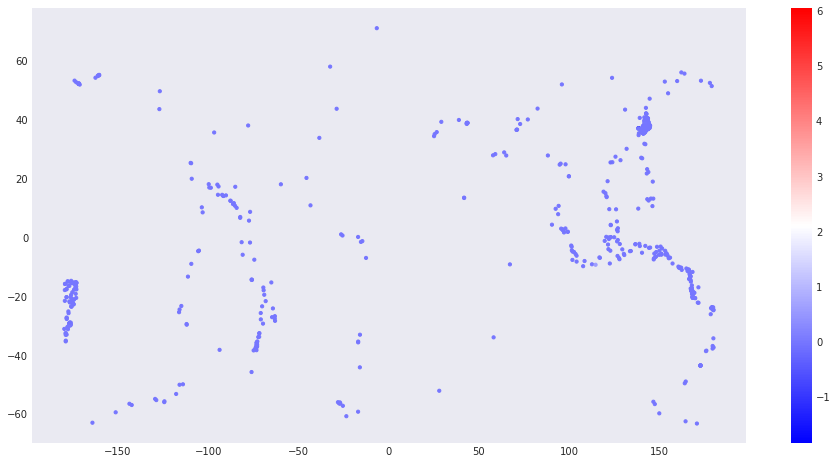

In [223]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

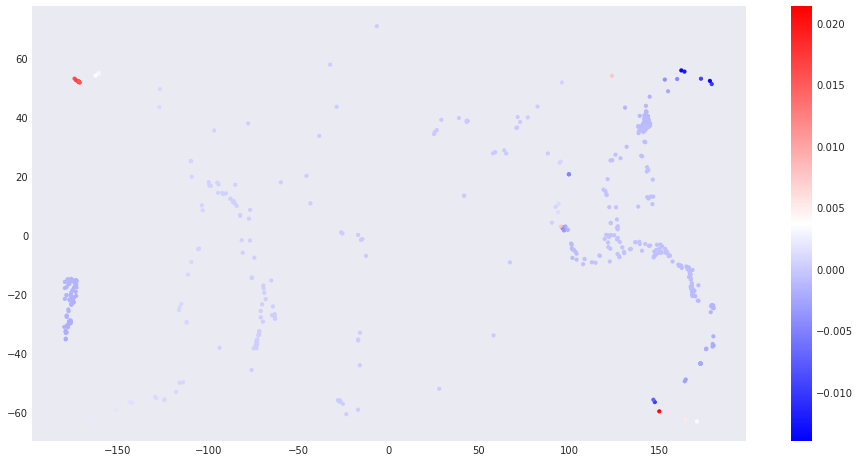

In [224]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

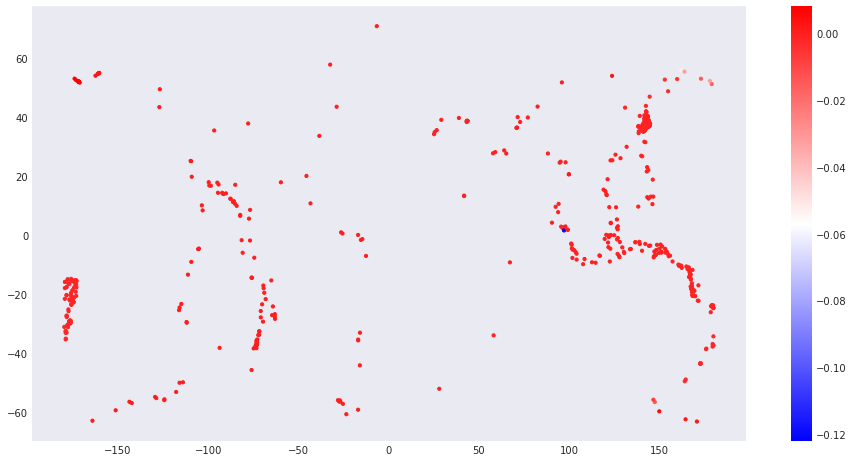

In [225]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

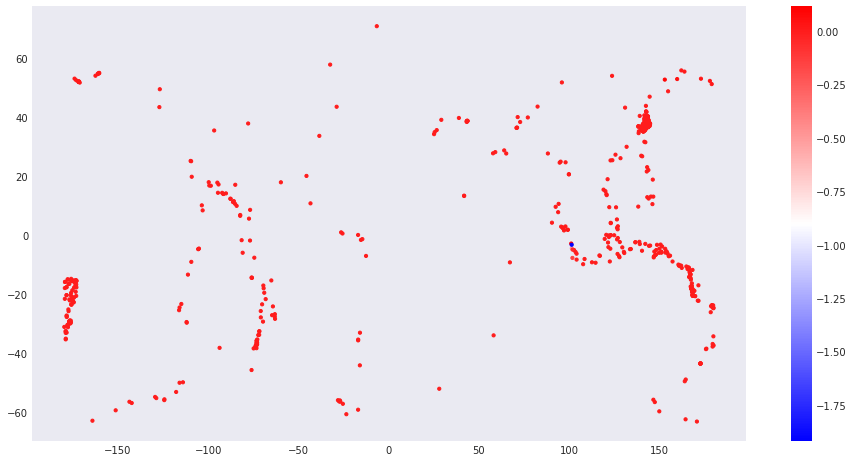

In [226]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

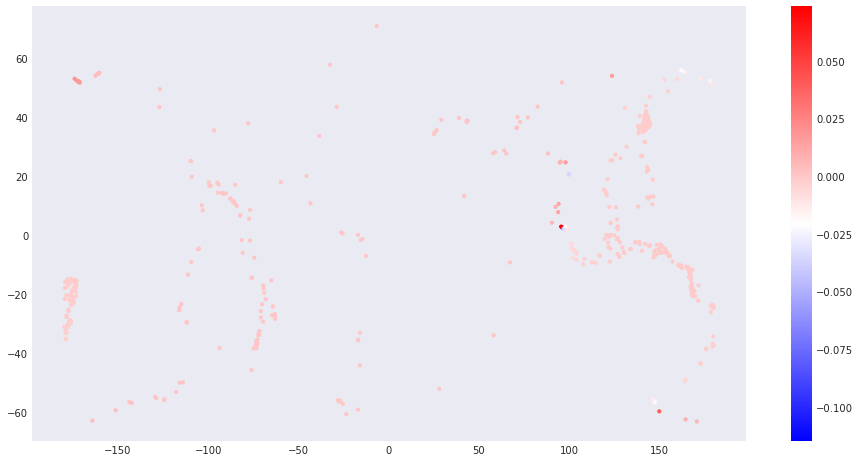

In [227]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

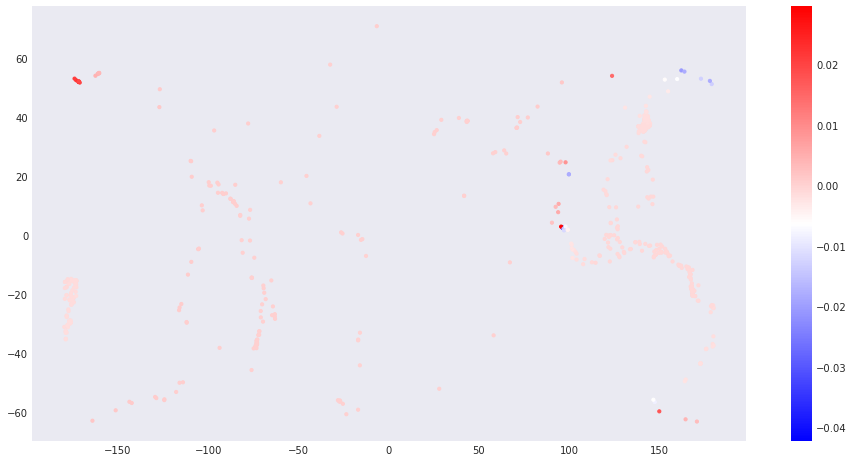

In [228]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()